In [9]:
import os, glob, sys
import time
import pandas as pd
import scipy as sp
import numpy as np
import statsmodels.api as sm

import nibabel as nib
from nilearn import plotting, masking, image, datasets

from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import plot_design_matrix

%matplotlib inline 

# Population-Level Effects Analysis

We currently include 7 studies (all except Temple ARF data which is still in pre-processing):
1. DARPA (outcome: NYTimes sharing)
2. Project 1 (combined model for Image & Banners Task) (click through rate)
3. Alcohol (Qualtrics panel intention ratings)
4. Cityyear (click-through)
5. Rotterdam Movietrailers (Rotten tomatoes public movie rating)
6. Rotterdam TV ads (Out of sample ad liking)
7. Stanford Youtube (Population view-frequency)

The first-pass model is a pmod of ranked out-of-sample outcomes.

In [10]:
MODEL_NAME = 'pmod_pop_rank'
GROUP_DIR = '/data00/projects/megameta/group_models/'
output_dir = os.path.join(GROUP_DIR, 'custom', 'model_2nd-level_lm-{}'.format(MODEL_NAME))
os.makedirs(output_dir, exist_ok=True)

In [11]:
root_dir = '/data00/projects/megameta'

datasource = {
'Movietrailers': 'rsm_movietrailer/derivatives/nipype/model_MOVIE_pmod_pop_rank',
'Movietrailers_star': 'rsm_movietrailer/derivatives/nipype/model_MOVIE_star_pmod_pop_rank',
'TVC': 'rsm_tvc35/derivatives/nipype/model_TVC_pmod_pop_rank',
'DARPA': 'darpa1/derivatives/nipype/model_SHARE_pmod_pop_rank',
'CityYear': 'cityyear/derivatives/nipype/model_MESSAGE_pmod_pop_rank',
'Alcohol': 'alcohol/derivatives/nipype/model_TASK_pmod_pop_rank',
'Stanford': 'stanford_041320/derivatives/nipype/model_WATCH_pmod_pop_rank',
'Stanford_rate': 'stanford_041320/derivatives/nipype/model_RATE_pmod_pop_rank',
'Project1': 'project1/derivatives/nipype/model_BANNER_IMAGE_pmod_pop_rank' }

In [13]:
if os.path.exists('contrast_list.csv'):
    contrast_df = pd.read_csv('contrast_list.csv')
else:
    contrast_list = []

    for study, study_path in datasource.items():
        print(f"Scanning {study}...", end = " ")
        con_files = glob.glob(os.path.join(root_dir, study_path, '*/*/*/con*.nii'))
        print(f"{len(con_files)} contrasts found.")

        for cf in con_files:
            description = nib.load(cf).header['descrip'].tolist().decode('utf-8')
            cf_parts = cf.split('/')

            entry = {
                'study': study,
                'subj': cf_parts[-4],
                'resolution': cf_parts[-3],
                'fwhm': cf_parts[-2],
                'path': cf,
                'contrast': description.split(": ")[-1],           
            }
            contrast_list.append(entry)
            print("*",end="")
        print("")
    
    contrast_df = pd.DataFrame(contrast_list)
    contrast_df.to_csv('contrast_list.csv',index=False)

Scanning Movietrailers... 100 contrasts found.
****************************************************************************************************
Scanning Movietrailers_star... 100 contrasts found.
****************************************************************************************************
Scanning TVC... 236 contrasts found.
********************************************************************************************************************************************************************************************************************************************
Scanning DARPA... 246 contrasts found.
******************************************************************************************************************************************************************************************************************************************************
Scanning CityYear... 156 contrasts found.
*************************************************************************************************

**Overview of contrasts available for each study**

In [14]:
contrast_df.groupby(['contrast','study']).describe().loc[:,('subj','count')]

contrast                                study             
constant                                Alcohol               56
                                        CityYear              39
                                        DARPA                 41
                                        Movietrailers         25
                                        Movietrailers_star    25
                                        Project1              48
                                        Stanford              40
                                        Stanford_rate         39
                                        TVC                   59
impure_message                          Alcohol               56
                                        DARPA                 41
impure_messagexint_pop_rank^1           Alcohol               56
impure_messagexpmod_pop_retrans_rank^1  DARPA                 41
non_message_event                       Alcohol               56
                               

In [18]:
included_contrasts = ['pure_messagexint_pop_rank^1',
                      'pure_messagexpmod_pop_ctrmean_rank^1',
                      'pure_messagexpmod_pop_rank^1',
                      'pure_messagexpmod_pop_retrans_rank^1',
                      'pure_messagexpopulation_CTR_rank^1' ,
                      'pure_messagexstar_pmod_pop_rank^1']

In [19]:
included_df = contrast_df[contrast_df.contrast.isin(included_contrasts)]
print(f"Duplicates: {included_df.duplicated(subset=['study','subj']).sum()}")

Duplicates: 0


**Number of subjects included per study (Note: one or two still missing from some studies)**

In [20]:
included_df.study.value_counts()

TVC                   59
Alcohol               56
Project1              48
DARPA                 41
Stanford              40
Stanford_rate         39
CityYear              39
Movietrailers_star    25
Movietrailers         25
Name: study, dtype: int64

# Sanity Checks & Overview of Individual studies

**Some Observations**

- Studies where outcomes are more proximal show stronger expected effect, i.e. medial wall+ striatum activation (self-reported perceptions of the actual stimulus in conditions similar to those of the scanner as opposed to large-scale behavior) -- the exception is DARPA which shows medial wall activity even for the more distal outcome

    - Very strong expected effects for TVC
    - Also looking good: Alcohol
    
- Studies with more distal outcomes show weaker effects and mostly more lateral regions including temporal lobes and insula

    - This includes Stanford data (Youtube views)
    - Movietrailers (Rotten tomato ratings)
    - Project 1 (Click through)
    - City Year (Click through)

>> Did double check direction of the DV for DARPA, TVC, Movietrailer, Cityyear, Alcohol

In [21]:
full_included_df = contrast_df[contrast_df.contrast.isin(included_contrasts)]

def make_intercept_only_zmap(study_list,output_dir,contrast_df=contrast_df,full_included_df=full_included_df,print_design_matrix=False):
    
    included_df=full_included_df[full_included_df.study.isin(study_list)]
    print(included_df['study'].unique())
    nsamples = len(included_df)
    
    DESCRIPTION=''
    for s in study_list:
        DESCRIPTION=DESCRIPTION+s

    design_matrix = pd.DataFrame({'intercept': [1] * nsamples})
    
    if print_design_matrix:
        plot_design_matrix(design_matrix)

    second_level_model = SecondLevelModel().fit(
        included_df.path.values.tolist(), design_matrix=design_matrix)

    z_map = second_level_model.compute_contrast('intercept', output_type='z_score')
    z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_{DESCRIPTION}_intercept_only.nii.gz'))

Movietrailers
['Movietrailers']


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Movietrailers_star
['Movietrailers_star']
TVC
['TVC']
DARPA
['DARPA']
CityYear
['CityYear']
Alcohol
['Alcohol']
Stanford
['Stanford']
Stanford_rate
['Stanford_rate']
Project1
['Project1']


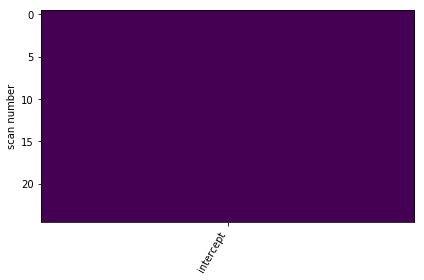

In [22]:
for count,s in enumerate(full_included_df['study'].unique()):
    print(s)
    if count==0:
        make_intercept_only_zmap(study_list=[s],output_dir='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/',print_design_matrix=True)
    else:
        make_intercept_only_zmap(study_list=[s],output_dir='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/')

## Inspect Single Study Intercept Maps

In [12]:
#mask = '/data00/tools/spm8/apriori/brainmask_th25.nii'
mask = image.math_img('np.sign(img)', img=datasets.fetch_atlas_aal().maps)
template = '/data00/projects/megameta/templates/reference_medium_wad.nii'
mask = image.resample_to_img(mask, template, interpolation='linear')

def plot_thresholded_z_map(zmap_path,uncorrected=True, uncorrected_threshold=.001, cluster_threshold=3, FDR=True, FDR_threshold=.05,cut_coords=()):
    
    %matplotlib inline
    z_map=nib.load(zmap_path)
    
    if uncorrected:
        thresholded_map, threshold = map_threshold(
            z_map, mask_img=mask, alpha=uncorrected_threshold, height_control='fpr', cluster_threshold=cluster_threshold)

        print(f"p < {uncorrected_threshold} uncorrected threshold: {threshold:.3f}")
        if len(cut_coords)==0:
            plotting.plot_stat_map(z_map, threshold=threshold)
        else:
            plotting.plot_stat_map(z_map, threshold=threshold,cut_coords=cut_coords)
    if FDR:
        thresholded_map, threshold = map_threshold(
            z_map, alpha=FDR_threshold, height_control='fdr')

        print(f"p < {FDR_threshold} FDR threshold: {threshold:.3f}")

        if len(cut_coords)==0:
            plotting.plot_stat_map(z_map, threshold=threshold)
        else:
            plotting.plot_stat_map(z_map, threshold=threshold,cut_coords=cut_coords)
    
    return z_map

**Alcohol Map**

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 3.371


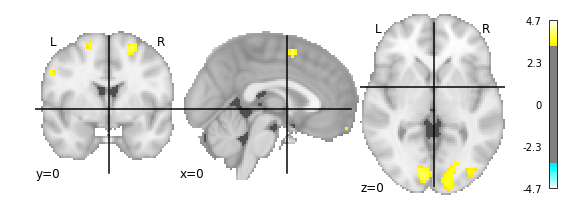

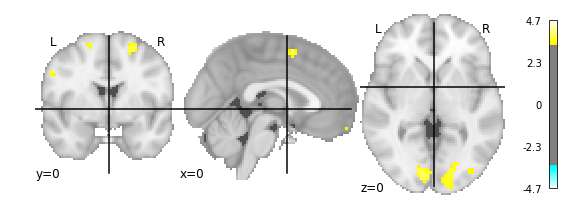

In [13]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_Alcohol_intercept_only.nii.gz')

**DARPA Map**

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: inf


/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


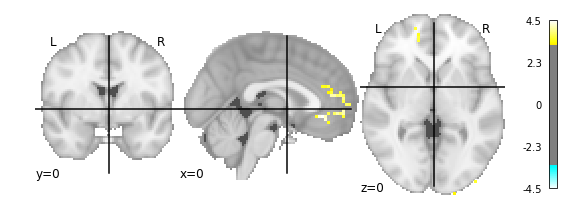

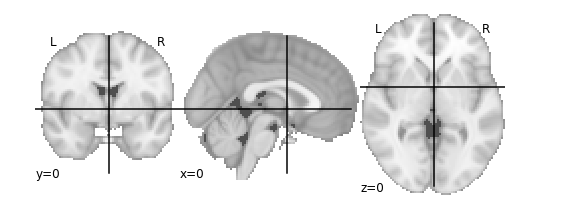

In [16]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_DARPA_intercept_only.nii.gz')


**CityYear Map**

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: inf


/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))



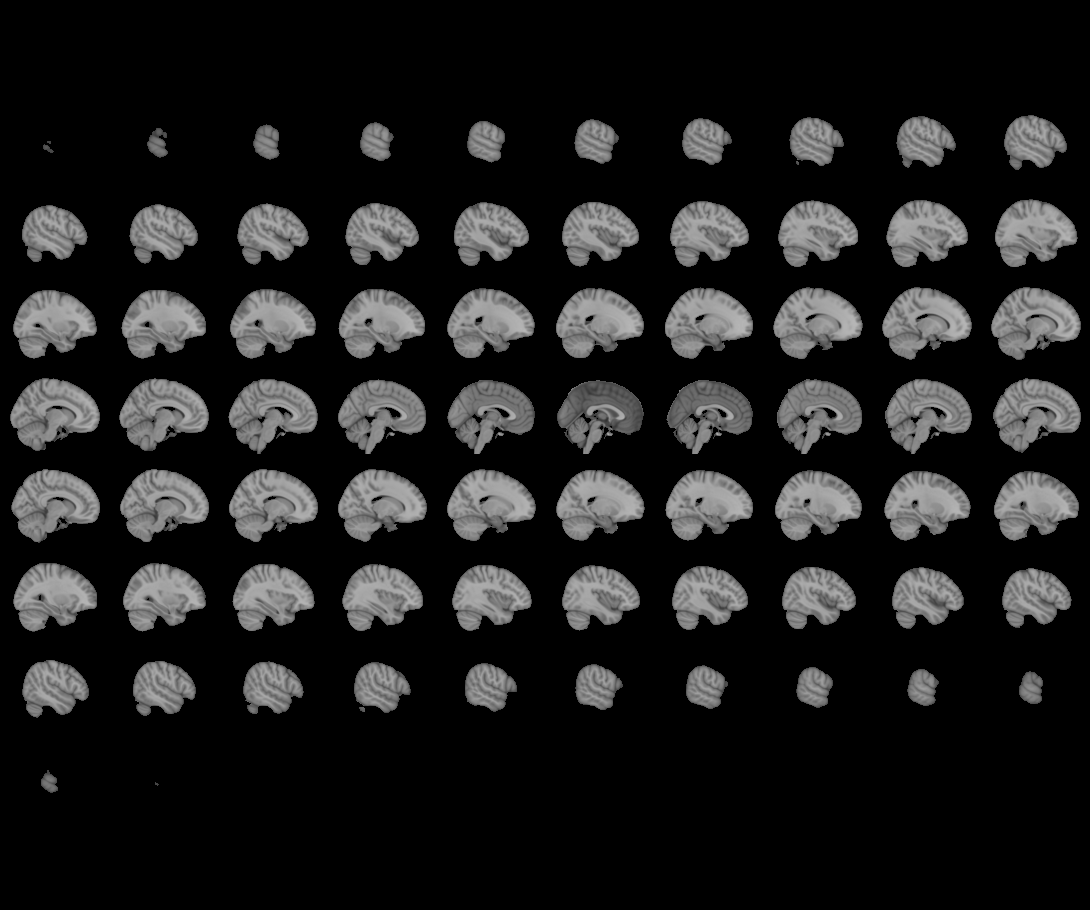
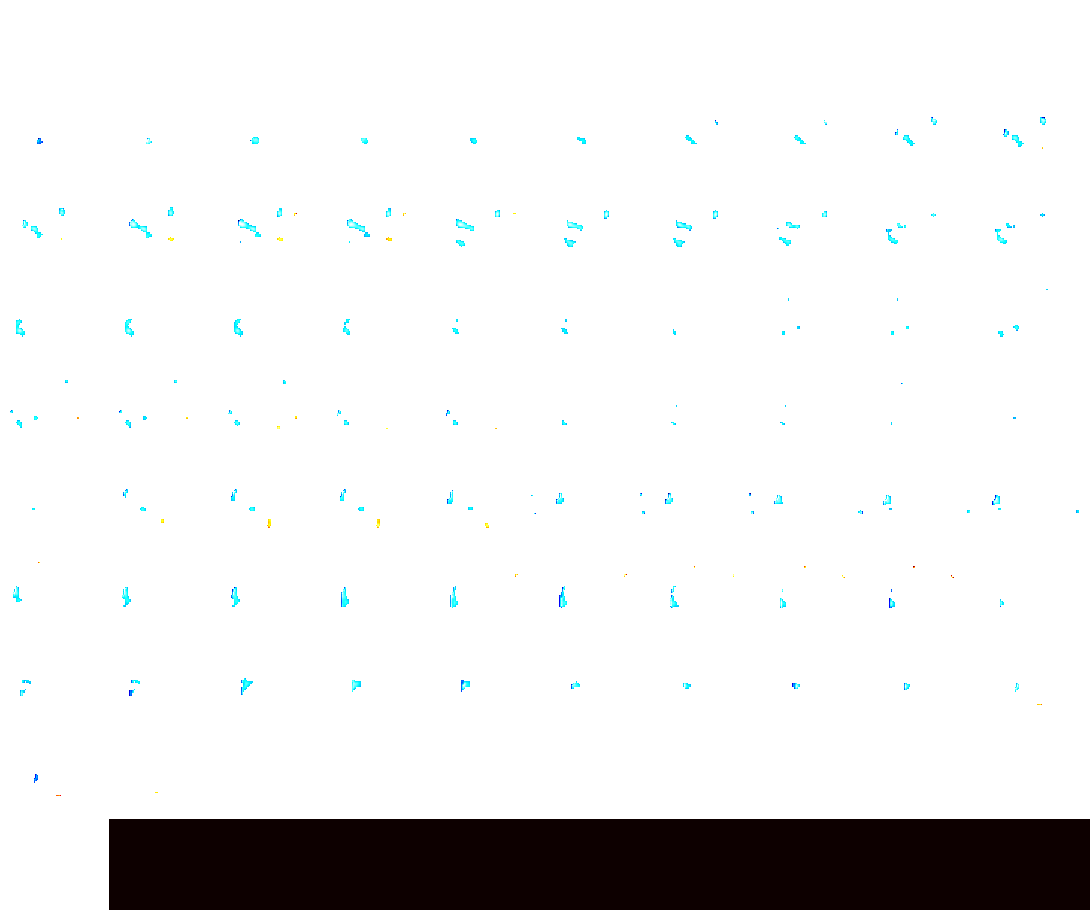

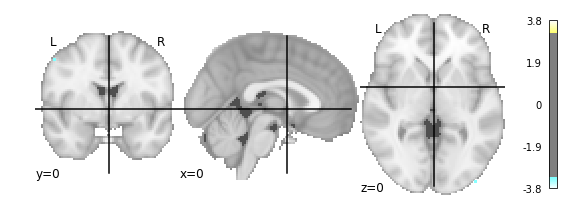

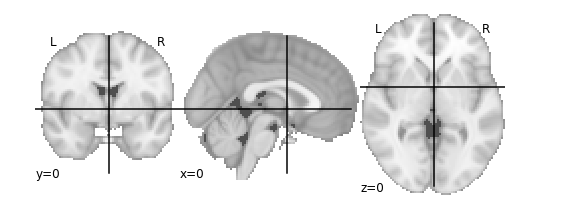

In [15]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_CityYear_intercept_only.nii.gz')
plotting.view_img(z_map,threshold=2.6)

## double check about outcome w/ Jason

**Project1 Map**

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 3.139



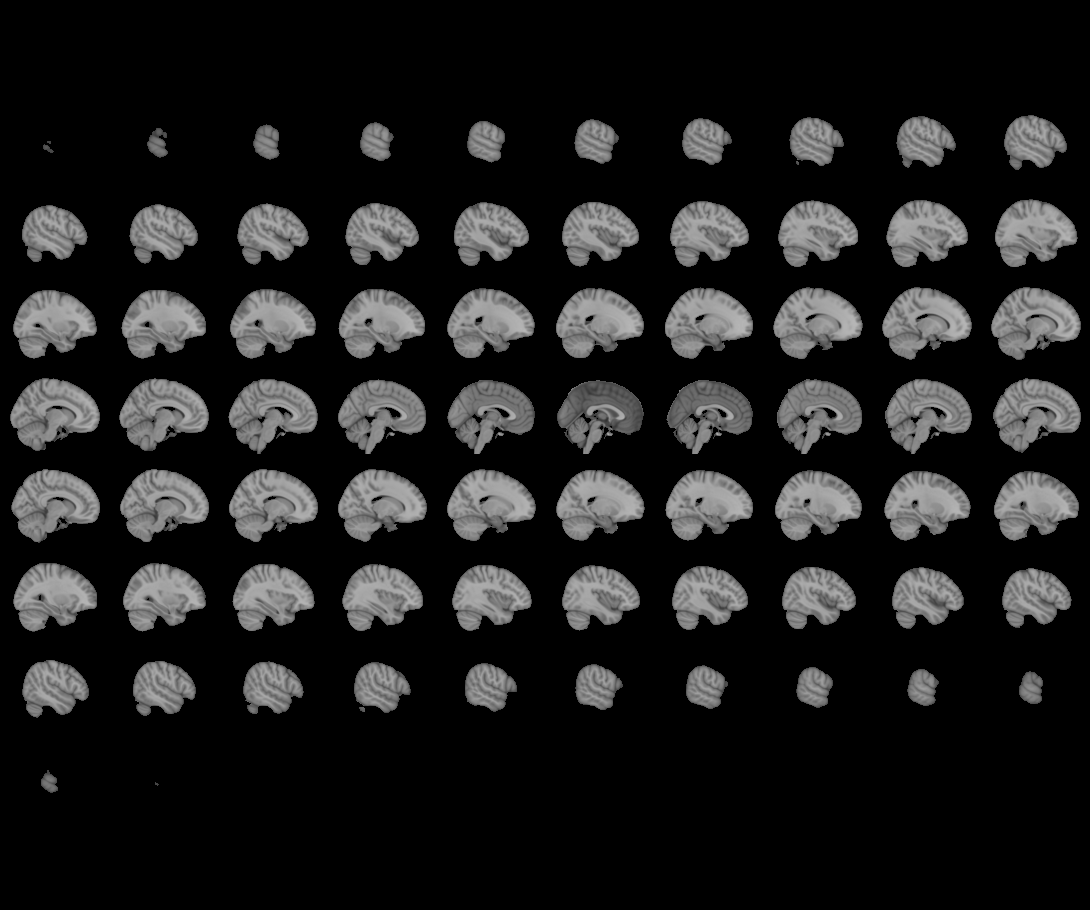
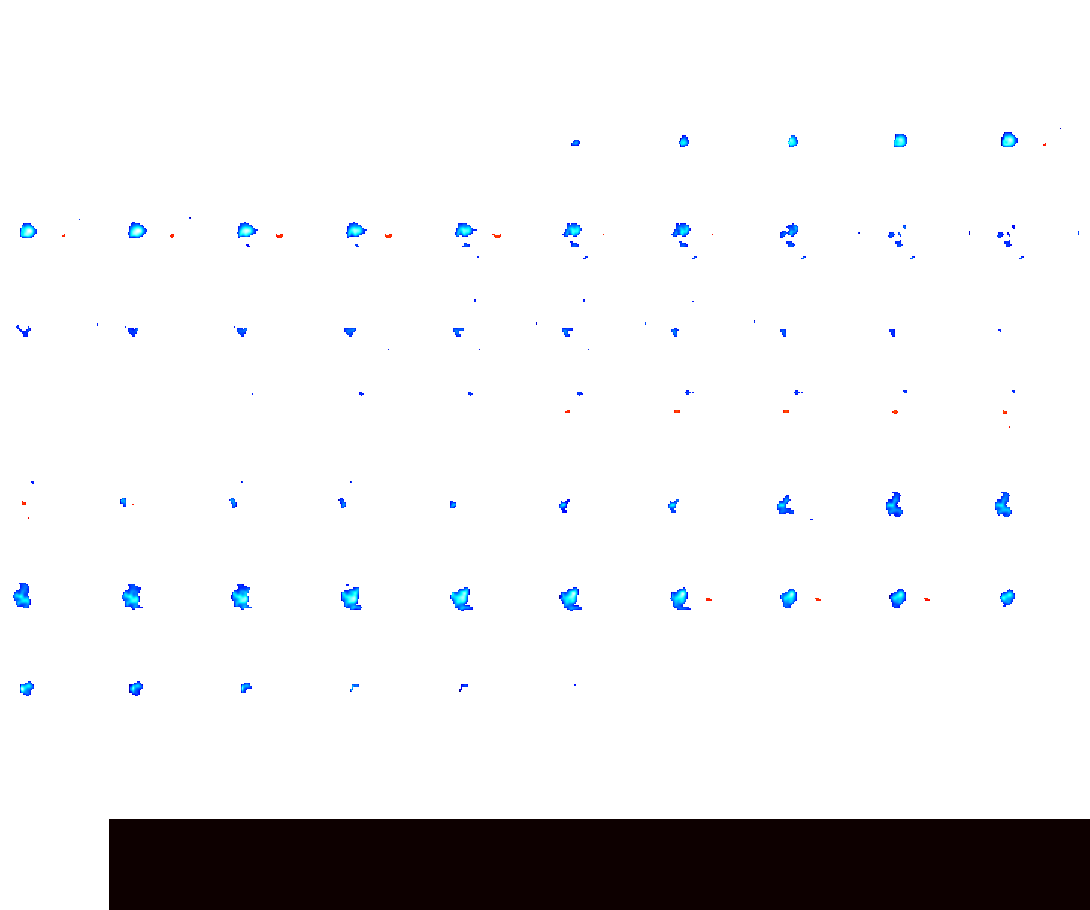

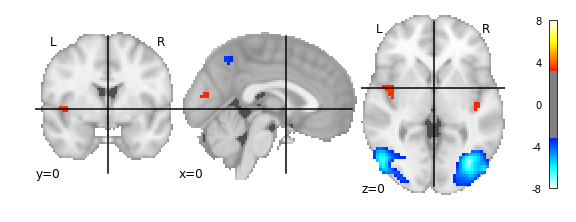

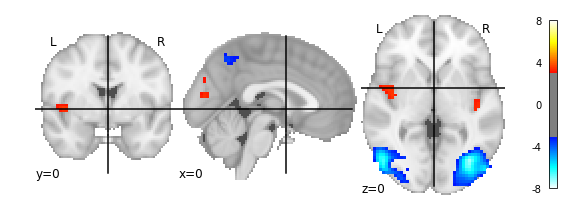

In [17]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_Project1_intercept_only.nii.gz')
plotting.view_img(z_map,threshold=3.2)
# 2 models?

**TVC Map**

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 2.637


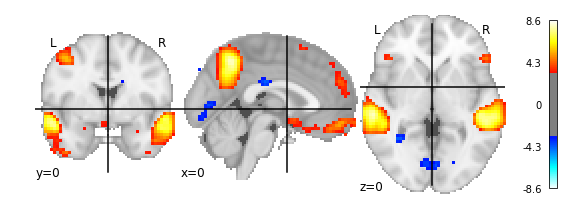

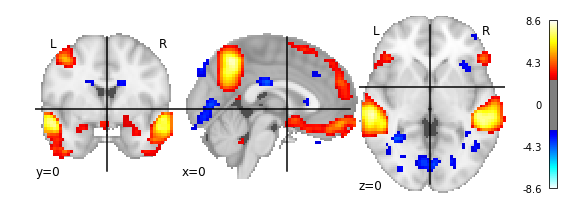

In [18]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_TVC_intercept_only.nii.gz')


**Movietrailers Map**

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 3.503


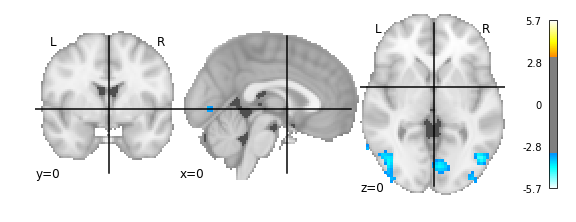

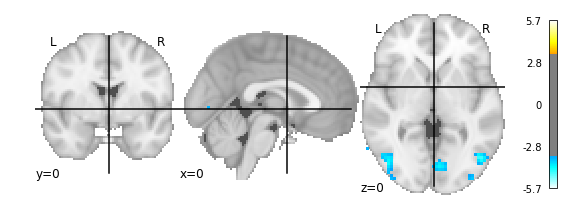

In [19]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_Movietrailers_intercept_only.nii.gz')


**Stanford Map**

- consider only modeling the first few seconds

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: inf


/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))



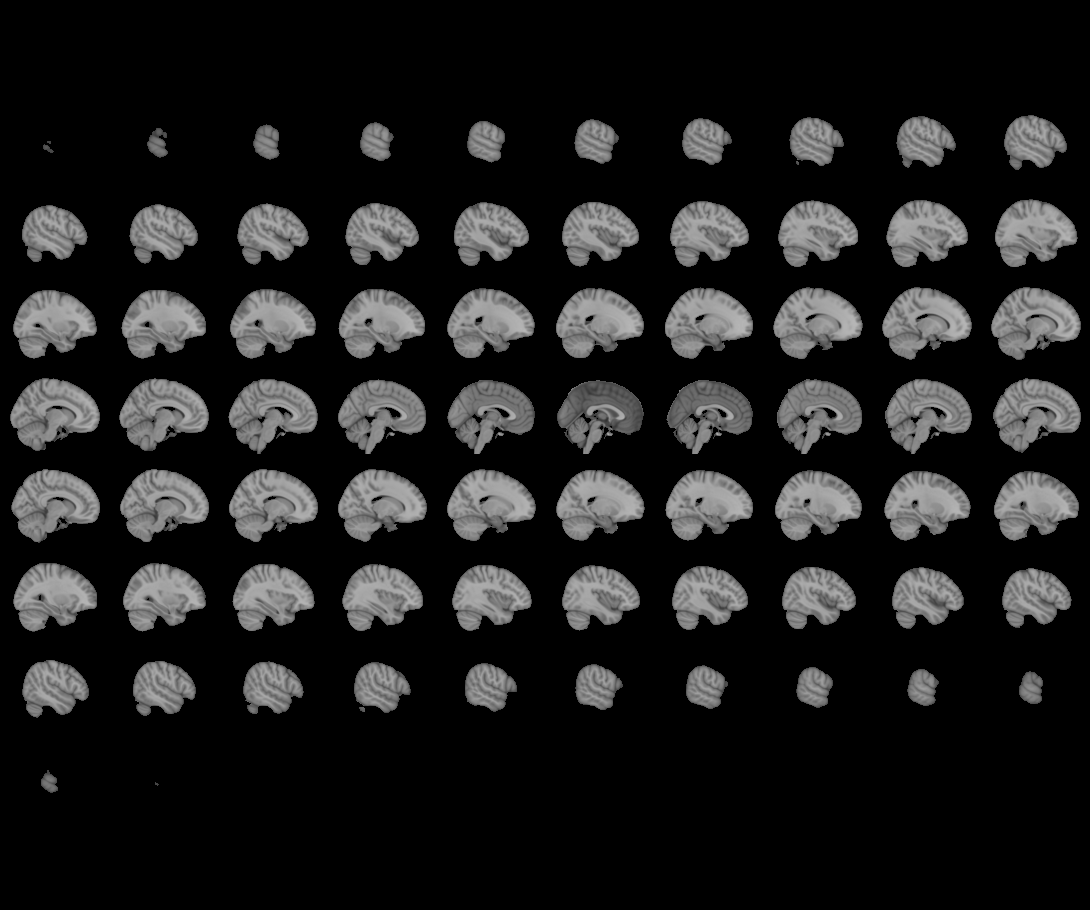
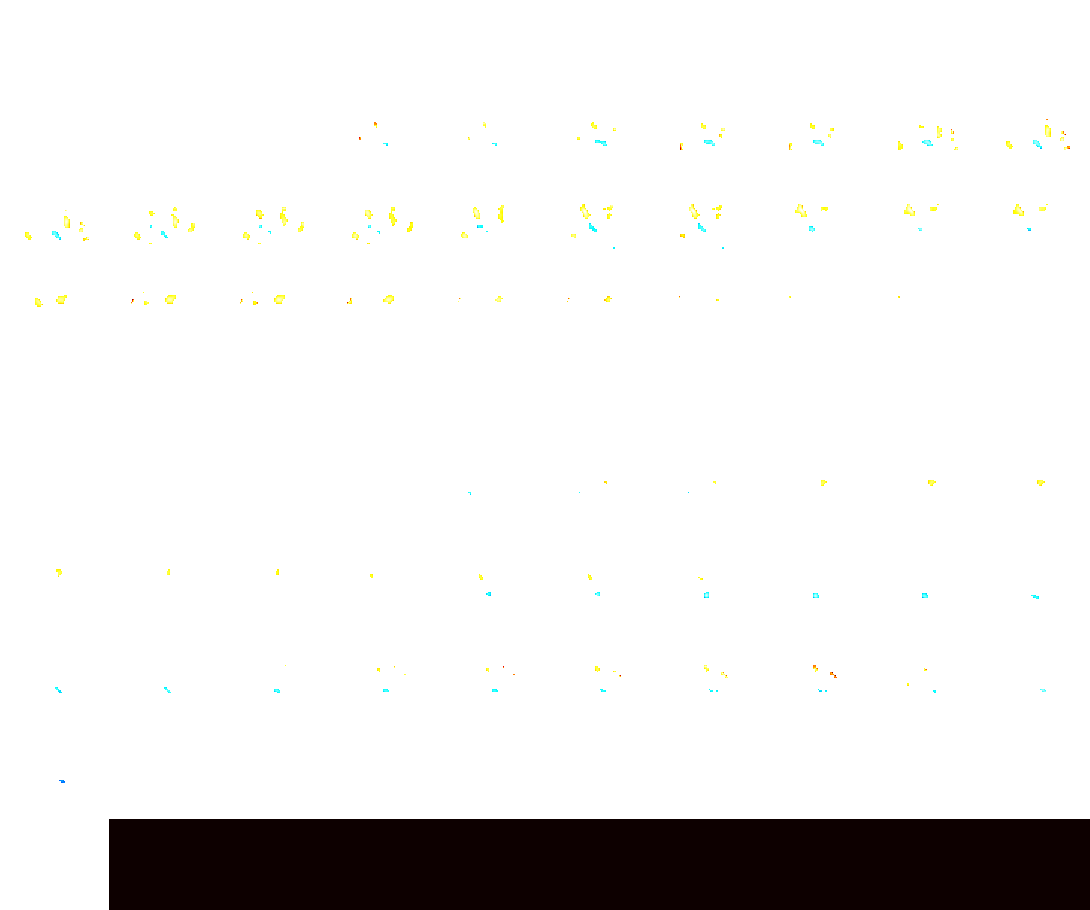

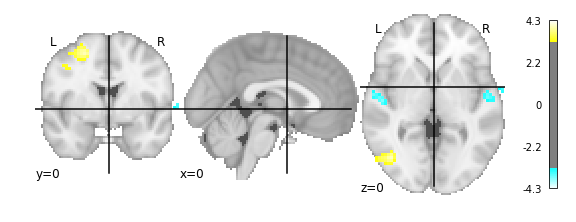

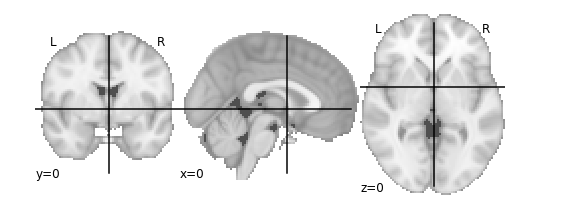

In [21]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_Stanford_intercept_only.nii.gz')
plotting.view_img(z_map,threshold=3.2)

# Mega-Analysis

We estimated different models:
1. Intercept only: Model does not control for study and simply gets average activation across ALL participants
2. Study fixed effects: Model includes a dummy regressor for each study. Still looking at the grand mean though.
3. Study random effects: In progress

## Intercept only

Not controlling for study.

### All Studies 

In [22]:
study_list=['Alcohol','DARPA','CityYear','Project1','Movietrailers','TVC','Stanford']
make_intercept_only_zmap(study_list=study_list,output_dir='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/')


['Movietrailers' 'TVC' 'DARPA' 'CityYear' 'Stanford' 'Project1' 'Alcohol']


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: inf


/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


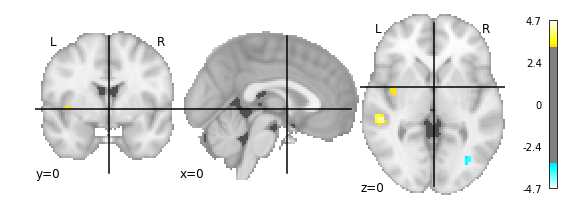

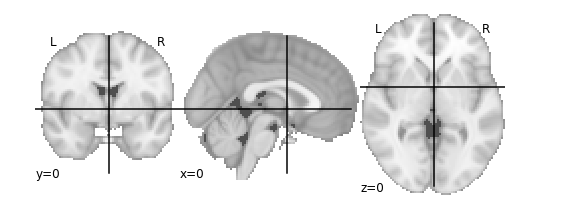

In [46]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),uncorrected_threshold=0.001,zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_AlcoholDARPACityYearProject1MovietrailersTVCStanford_intercept_only.nii.gz')


### Proximal (Out-of-Sample Outcome) Studies + DAPRA

In [25]:
study_list=['Alcohol','DARPA','TVC']
make_intercept_only_zmap(study_list=study_list,output_dir='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/')

['TVC' 'DARPA' 'Alcohol']


p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 3.212



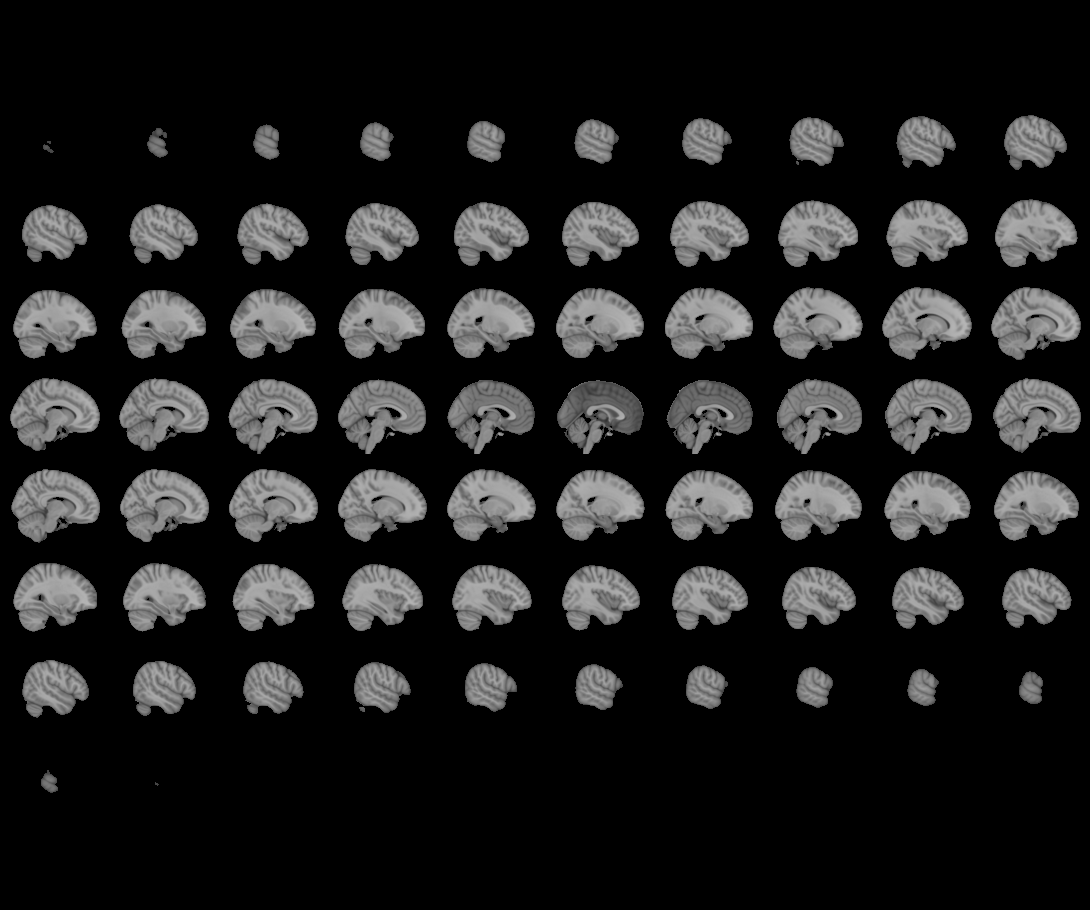
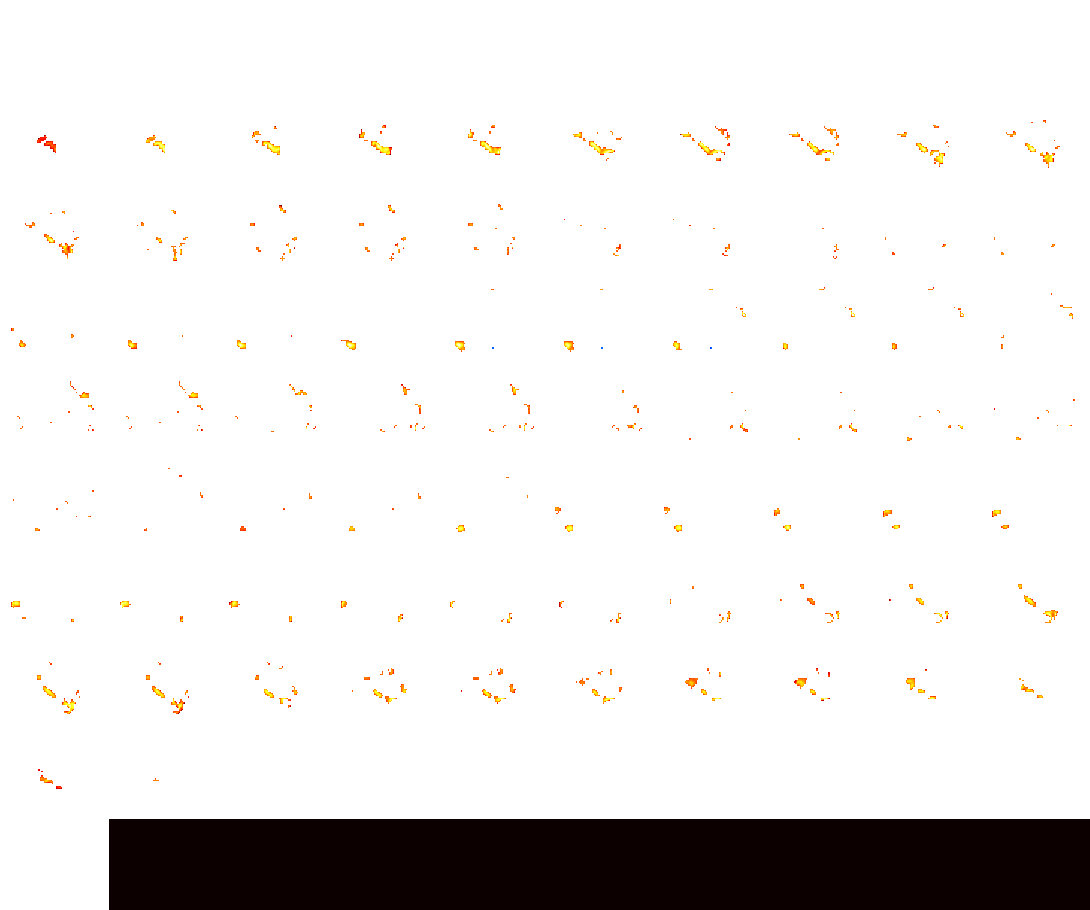

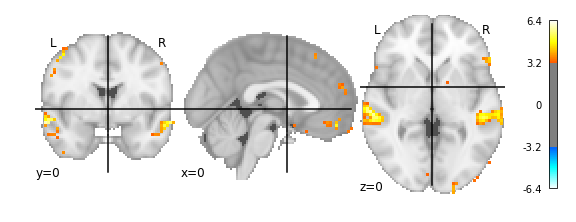

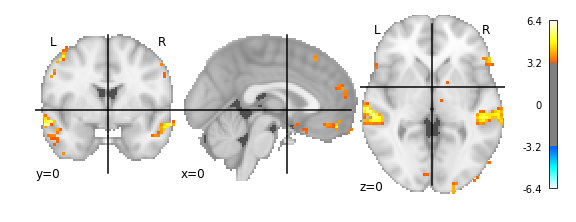

In [27]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_AlcoholDARPATVC_intercept_only.nii.gz')
plotting.view_img(z_map,threshold=3.212)

### Distal (Population-Level) Outcome Studies

In [28]:
study_list=['DARPA','Stanford','Movietrailers','Project1','CityYear']
make_intercept_only_zmap(study_list=study_list,output_dir='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/')
                         
                         
                    

['Movietrailers' 'DARPA' 'CityYear' 'Stanford' 'Project1']


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 4.464



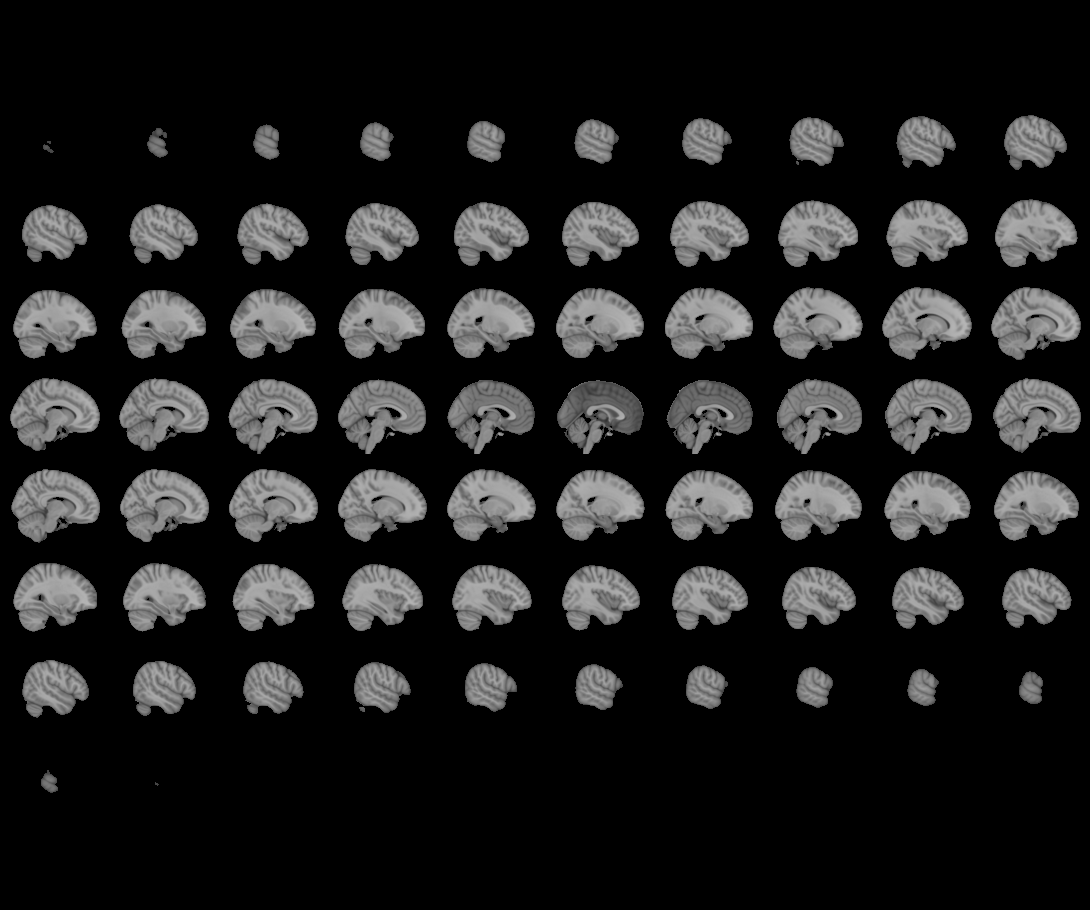
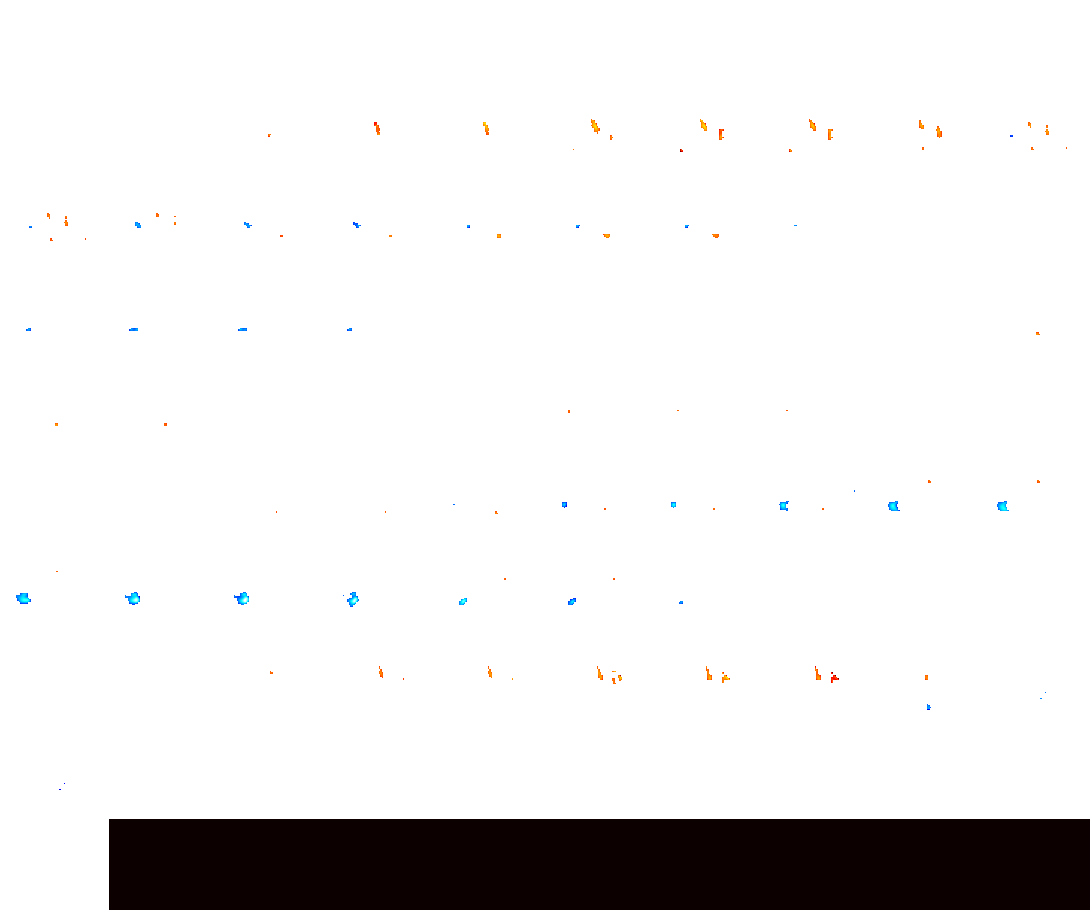

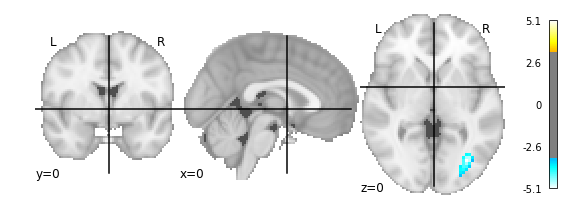

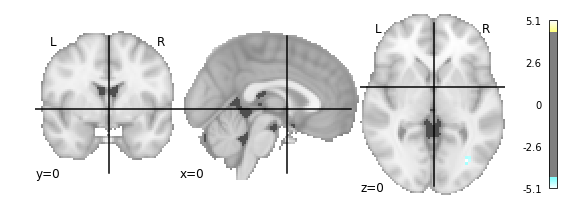

In [30]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_DARPAStanfordMovietrailersProject1CityYear_intercept_only.nii.gz')
plotting.view_img(z_map,threshold=2.6)

## Study fixed effects

Controlling for study but still looking at grand mean

In [31]:
full_included_df = contrast_df[contrast_df.contrast.isin(included_contrasts)]

def make_fixed_effects_zmap(study_list,output_dir,contrast_df=contrast_df,full_included_df=full_included_df,print_design_matrix=False):
    
    included_df=full_included_df[full_included_df.study.isin(study_list)]
    print(study_list)
    nsamples = len(included_df)
    
    DESCRIPTION=''
    for s in study_list:
        DESCRIPTION=DESCRIPTION+s

    design_matrix = pd.get_dummies(included_df.study)
    design_matrix -= np.mean(design_matrix.values)
    design_matrix['intercept'] = 1
    plot_design_matrix(design_matrix)
    
    #if print_design_matrix:
    #    plot_design_matrix(design_matrix)

    second_level_model = SecondLevelModel().fit(
        included_df.path.values.tolist(), design_matrix=design_matrix)

    z_map = second_level_model.compute_contrast('intercept', output_type='z_score')
    z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_{DESCRIPTION}_study_fixed_effects.nii.gz'))

**All Studies**

['Movietrailers' 'TVC' 'DARPA' 'CityYear' 'Stanford' 'Project1' 'Alcohol']


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


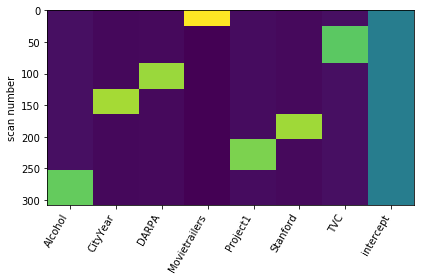

In [32]:
make_fixed_effects_zmap(study_list=full_included_df['study'].unique(),output_dir='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/',print_design_matrix=True)


p < 1 uncorrected threshold: 0.000
p < 0.05 FDR threshold: inf


/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


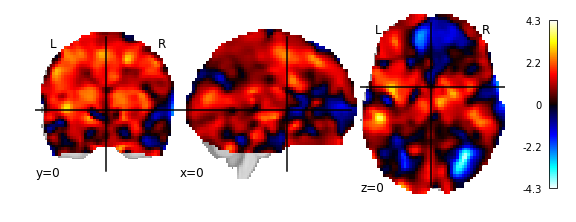

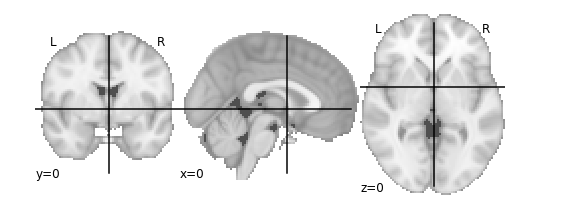

In [45]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),uncorrected_threshold=1,zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_MovietrailersTVCDARPACityYearStanfordProject1Alcohol_study_fixed_effects.nii.gz')


## Comparing Study Groups to Each Other

In [39]:
full_included_df = contrast_df[contrast_df.contrast.isin(included_contrasts)]

def make_fixed_effects_CompareGroups_zmap(Group1_study_list,Group1_name,DESCRIPTION,output_dir,study_list=[],contrast_df=contrast_df,Excluded_Studies_List=[],full_included_df=full_included_df,print_design_matrix=False):
    
    if len(study_list)>0:
        print('Included Studies: {}'.format(study_list))
        included_df=full_included_df[full_included_df.study.isin(study_list)]
    else:
        included_df=full_included_df
        
    nsamples = len(included_df)
    
    print('Group 1 Name: {}'.format(Group1_name))
    print('Group 1 List: {}'.format(Group1_study_list))
    print('Model name description: {}'.format(DESCRIPTION))
    print('Excluded Studies: {}'.format(Excluded_Studies_List))
    
    study_list=[s for s in included_df['study'].unique()]
        
    design_matrix = pd.DataFrame()
    design_matrix[Group1_name] = included_df.study.isin(Group1_study_list).astype(int)
    if len(Excluded_Studies_List)>0:
        design_matrix['excluded_studies'] = included_df.study.isin(Excluded_Studies_List).astype(int)
    design_matrix['intercept'] = 1
    plot_design_matrix(design_matrix)


    second_level_model = SecondLevelModel().fit(
        included_df.path.values.tolist(), design_matrix=design_matrix)

    z_map = second_level_model.compute_contrast(Group1_name, output_type='z_score')
    z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_{DESCRIPTION}_study_fixed_effects.nii.gz'))

**Marketing>Health (Intercept=Health)**

Group 1 Name: marketing
Group 1 List: ['TVC', 'Stanford', 'Movietrailers']
Model name description: Marketing>Health_healthintercept
Excluded Studies: ['CityYear']


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


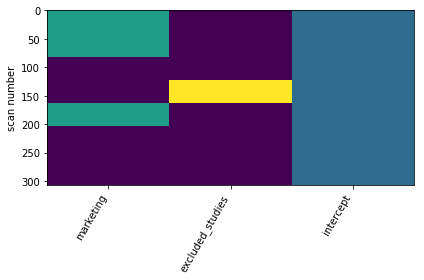

In [40]:
make_fixed_effects_CompareGroups_zmap(Group1_study_list=['TVC','Stanford','Movietrailers'],Group1_name='marketing',Excluded_Studies_List=['CityYear'],DESCRIPTION='Marketing>Health_healthintercept',output_dir='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/')
#leaving out cityyear here

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 3.598



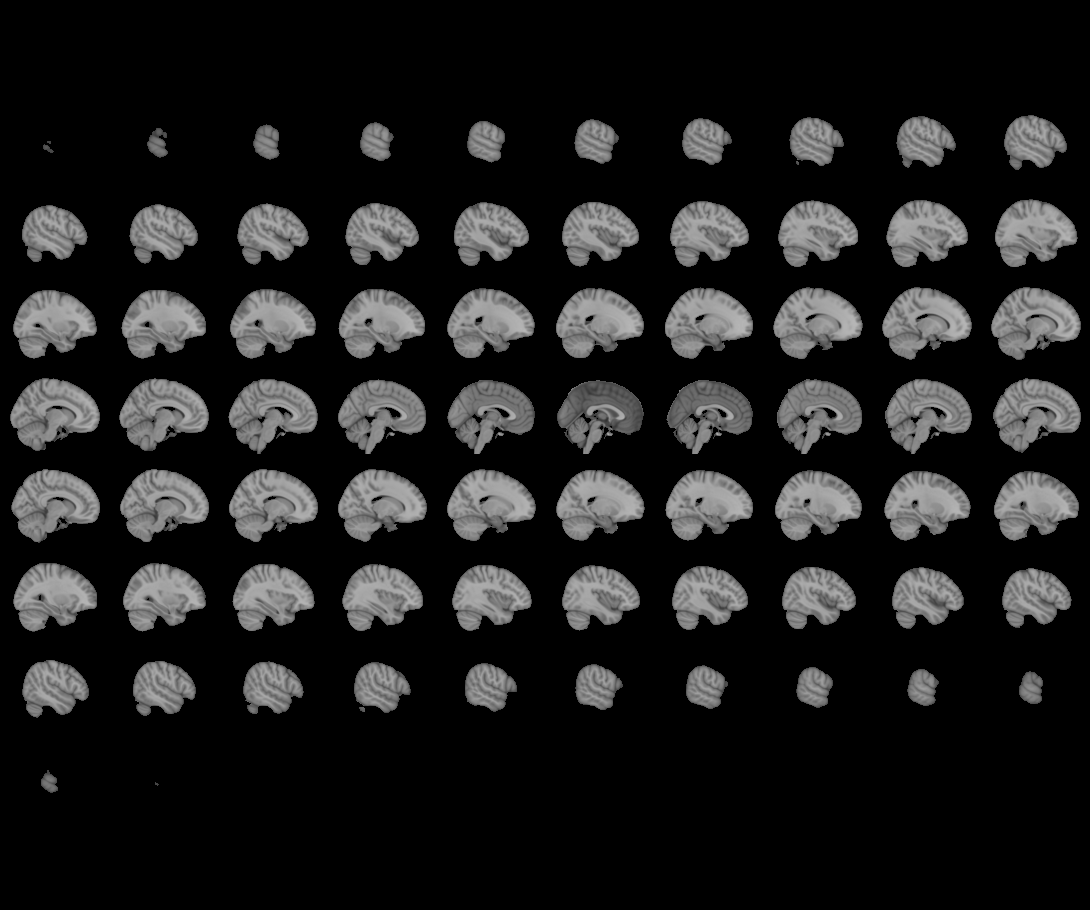
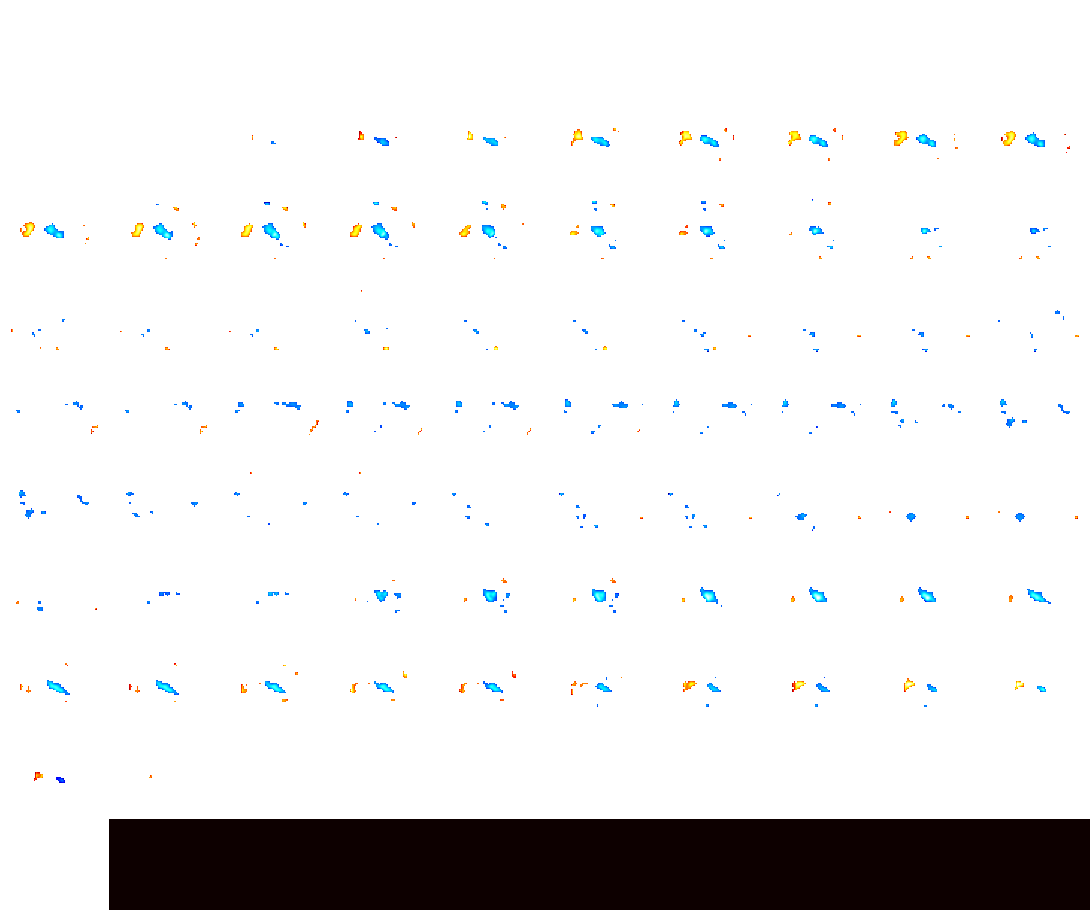

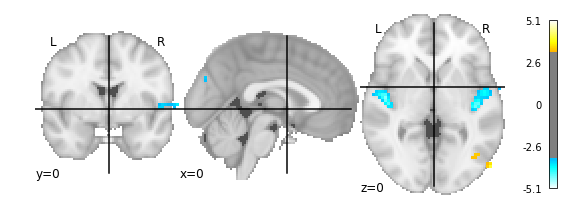

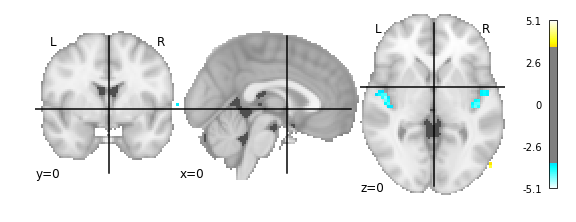

In [41]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/group_models/custom/model_2nd-level_lm-pmod_pop_rank/pmod_pop_rank_Marketing>Health_healthintercept_study_fixed_effects.nii.gz')
plotting.view_img(z_map,threshold=2.6)

## Marketing vs Health with study fixed effects (?????)

In [ ]:
marketing_studies = ['TVC', 'Stanford', 'Movietrailers']

In [ ]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)

design_matrix['marketing'] = included_df.study.isin(marketing_studies).astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects_health_intercept.nii.gz'))

In [ ]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)

design_matrix['health'] = 1 - included_df.study.isin(marketing_studies).astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects_marketing_intercept.nii.gz'))

# Cluster robust regression

p < 0.001 uncorrected threshold: 3.291
p < 0.05 FDR threshold: 4.615


/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



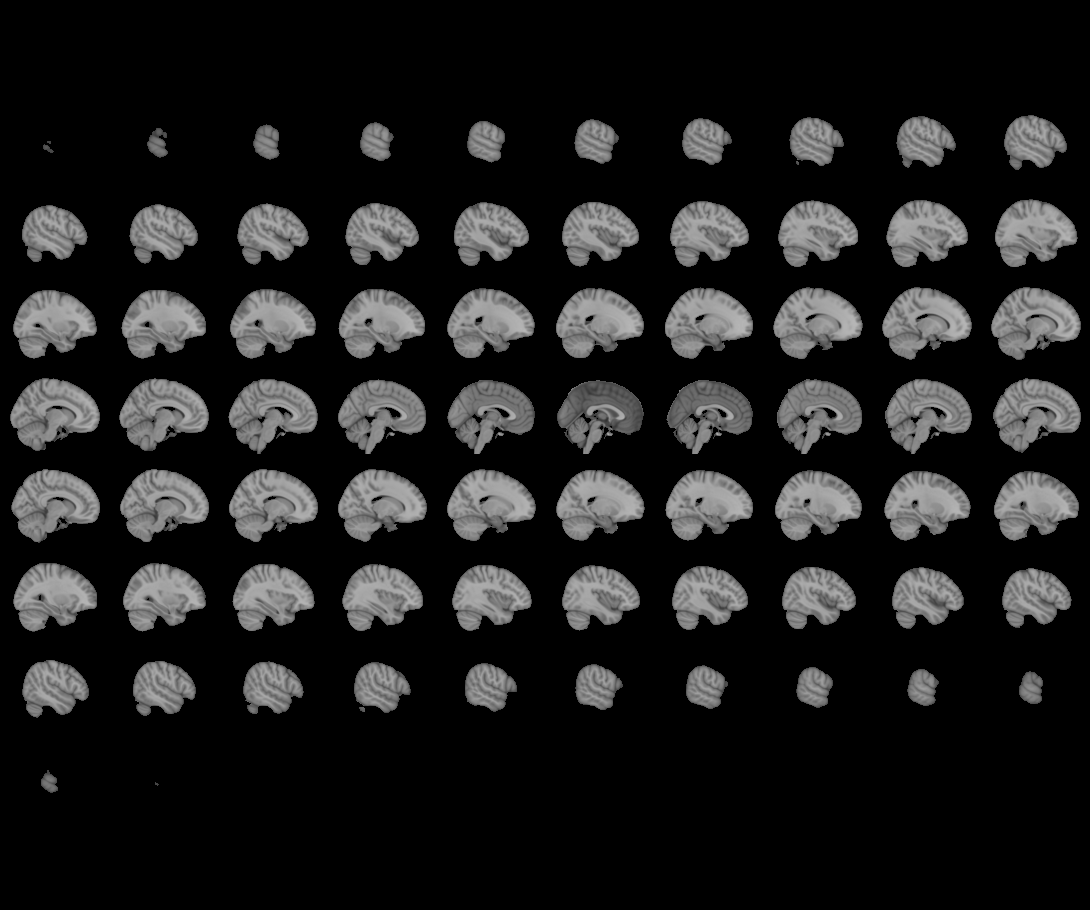
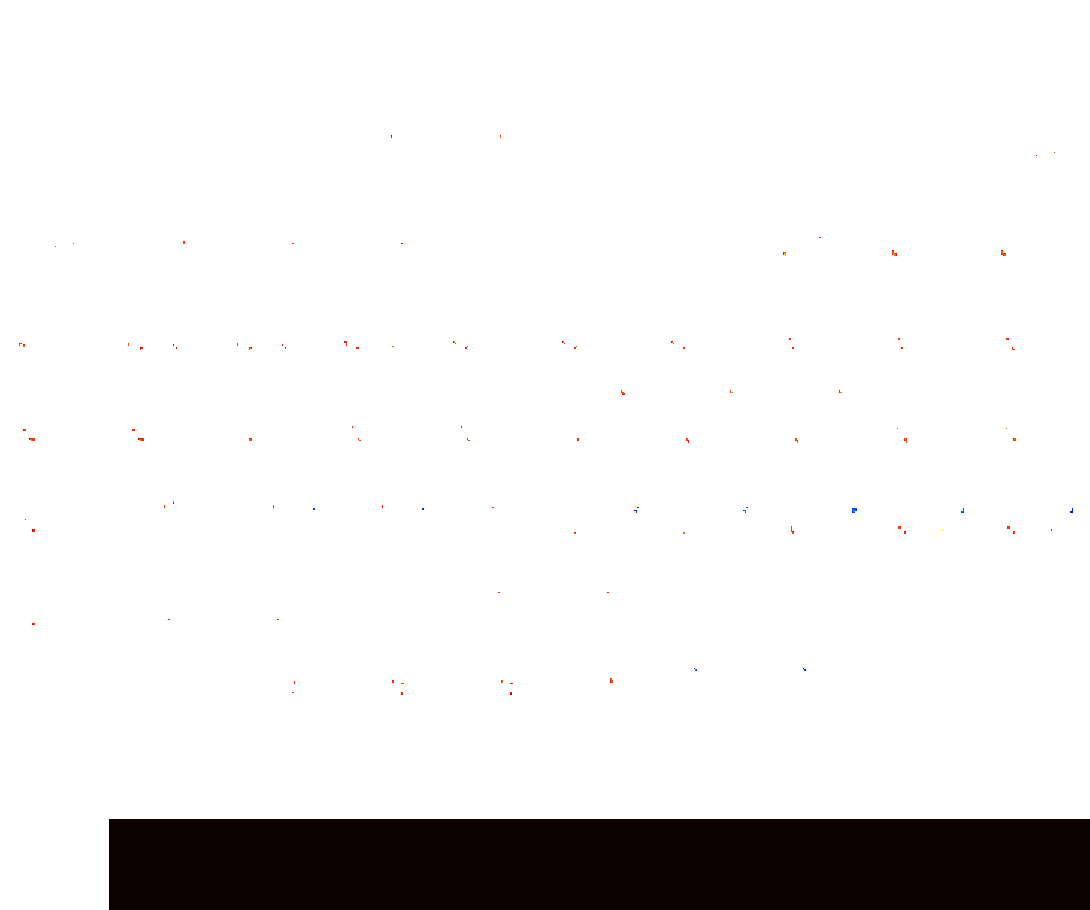

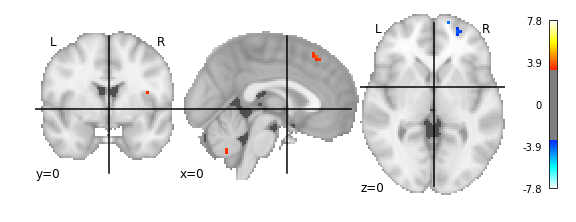

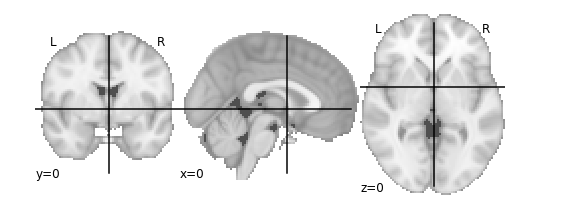

In [50]:
z_map=plot_thresholded_z_map(cut_coords=(0,0,0),zmap_path='/data00/projects/megameta/scripts/jupyter_megameta/cnlab/GLM/cluster_robust.nii.gz')
plotting.view_img(z_map,threshold=3.291)